### Install Required Libs

In [ ]:
!pip install -r requirements.txt

### Get Available Device

In [1]:
from utils import get_device
device = get_device()
print("Device:", device)

Device: cuda


### Prepare MNIST dataset

In [2]:
from utils import get_mnist_transform, get_minst_dataset

train_transform, test_transform = get_mnist_transform()

train_data = get_minst_dataset('train', train_transform)
test_data = get_minst_dataset('test', test_transform)

In [3]:
from utils import get_data_loader

batch_size = 512
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = get_data_loader(test_data, kwargs)
train_loader = get_data_loader(train_data, kwargs)

### Visualize Samples

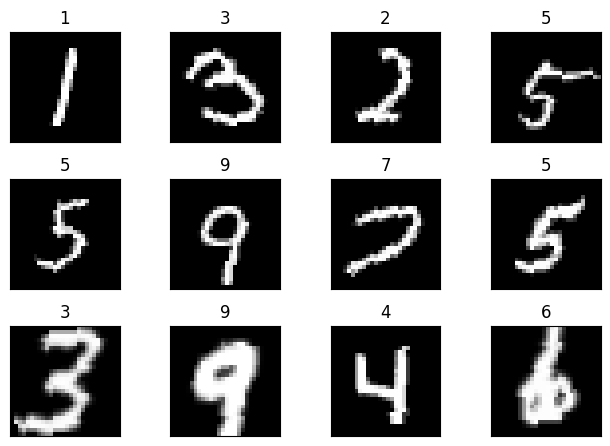

In [4]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

### Load model and get summary

In [5]:
from model import Net
from utils import model_summary

model = Net().to(device)
model_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


### Run Model Pipeline

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3680 Batch_id=117 Accuracy=54.89: 100%|██████████| 118/118 [00:09<00:00, 12.68it/s]


Test set: Average loss: 0.1881, Accuracy: 9447/10000 (94.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1498 Batch_id=117 Accuracy=94.55: 100%|██████████| 118/118 [00:10<00:00, 11.61it/s]


Test set: Average loss: 0.0789, Accuracy: 9771/10000 (97.71%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0694 Batch_id=117 Accuracy=96.57: 100%|██████████| 118/118 [00:09<00:00, 12.50it/s]


Test set: Average loss: 0.0529, Accuracy: 9847/10000 (98.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0722 Batch_id=117 Accuracy=97.32: 100%|██████████| 118/118 [00:10<00:00, 11.77it/s]


Test set: Average loss: 0.0535, Accuracy: 9818/10000 (98.18%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0894 Batch_id=117 Accuracy=97.76: 100%|██████████| 118/118 [00:09<00:00, 12.53it/s]


Test set: Average loss: 0.0380, Accuracy: 9881/10000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-02.


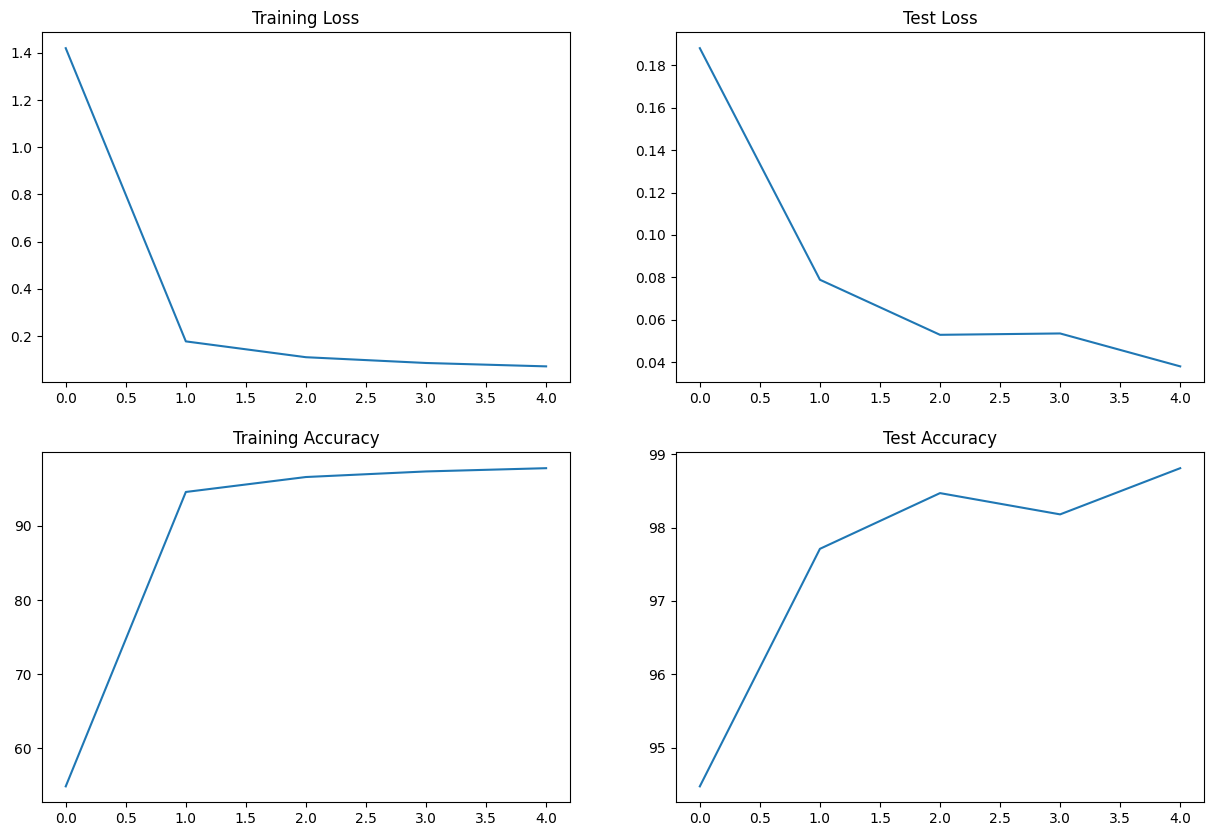

In [6]:
from utils import TTPipeline
import torch.nn.functional as F
import torch.optim as optim

ttp = TTPipeline(model, device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.cross_entropy # nn.CrossEntropyLoss()
num_epochs = 5

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    ttp.train(train_loader, optimizer, criterion)
    ttp.test(test_loader, criterion)
    scheduler.step()

ttp.print_performance()

### Visualize Model

In [19]:
from torchviz import make_dot

batch = next(iter(train_loader))
model.eval()
yhat = model(batch[0].to(device)) # Give dummy batch to forward().

make_dot(yhat, params=dict(list(model.named_parameters()))).render("mnist", format="png")

'mnist.png'